# 1) NetworkxEntityGraph

https://python.langchain.com/docs/use_cases/graph/integrations/graph_networkx_qa#create-the-graph

In [3]:
# import libraries
from langchain.indexes import GraphIndexCreator
from langchain.indexes.graph import NetworkxEntityGraph
from langchain_community.llms import Ollama
from langchain_openai import OpenAI
from langchain.chains import GraphQAChain
import networkx as nx
import pandas as pd
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
# # read csv file and skip first row
# highway_type = pd.read_csv('edge_labels_highways.csv', header=None, skiprows=1,
#                  names=['edge', 'highway type'])
# # split the first column into two columns
# highway_type['edge'] = highway_type['edge'].apply(lambda x: eval(x))

# # Split the 'edge' column into two columns 'start' and 'end'
# highway_type[['startNode', 'endNode']] = highway_type['edge'].apply(pd.Series)
# # convert the values into strings
# highway_type['startNode'] = highway_type['startNode'].astype(str)
# highway_type['endNode'] = highway_type['endNode'].astype(str)
# # Drop the 'edge' column
# highway_type.drop('edge', axis=1, inplace=True)

# # create networkx graph based on csv files
# G = nx.read_edgelist("..\\csv\\edges_UH_Graph.csv", delimiter=",", create_using=nx.DiGraph(), nodetype=str)
# # add labels to edges according to highway
# for u,v in G.edges():
#     if (u,v) in zip(highway_type['startNode'], highway_type['endNode']):
#         G[u][v]['relation'] = 'highway type: ' + str(highway_type['highway type'].loc[(highway_type['startNode'] == u) & (highway_type['endNode'] == v)].values[0])
#     else:
#         G[u][v]['relation'] = 'highway type: unknown'

# # write the graph to a GML file
# nx.write_gml(G, "UH_Graph.gml")

# # read the graph from the GML file
# G = nx.read_gml("UH_Graph.gml")

# # load gml graph as NetworkxEntityGraph
# G = nx.read_gml("UH_Graph.gml")
# G_NX = NetworkxEntityGraph(G)

# # print amount of nodes
# print("Nodes:", G_NX.get_number_of_nodes())

In [4]:
# # define the chain
# chain = GraphQAChain.from_llm(OpenAI(), graph = G_NX, verbose = True)

# # prompt
# node_1 = '31404364'
# node_2 = '313157654'

# prompt = 'Which is the highway type between node {node_1} and node {node_2} from the graph you received as input?'

# # chain.run(prompt)

### Problem: This is created for Knowledge Graphs, not for our graph!!

# 2) Special nodes

In [1]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import folium
import matplotlib.pyplot as plt

In [2]:
# read special nodes from csv file
with open('..\\csv\\special_nodes_UH_Graph_selection.csv') as f:
    special_nodes = str(f.readlines())
special_nodes_csv = pd.read_csv('..\\csv\\special_nodes_UH_Graph_selection.csv')

# read case examples from csv file with index
examples = pd.read_csv('..\\..\\Playground_LLM\\examples.csv', sep=';')
examples = examples.drop(columns=['Unnamed: 1'])

In [34]:
# # read special nodes
# special_nodes_csv = pd.read_csv('..\\csv\\special_nodes_UH_Graph.csv')
# # from special_nodes_csv list all nodes with same latitude and longitude
# special_nodes_duplicates = special_nodes_csv[special_nodes_csv.duplicated(subset=['lat', 'lon'], keep=False)]
# # sort by lat
# special_nodes_duplicates = special_nodes_duplicates.sort_values(by=['lat'])
# special_nodes_duplicates

In [3]:
# Create a map
m = folium.Map(location=[48.006, 7.837], zoom_start=8,
               zoom_control=False, scrollWheelZoom=True)
# Defining the map boundaries 
m.fit_bounds([[48.0048000, 7.8357000], [48.0081000, 7.8391000]])

# add marker to all special nodes
for i in range(len(special_nodes_csv)):
    folium.Marker(
        location=[special_nodes_csv.iloc[i]['lat'], special_nodes_csv.iloc[i]['lon']],
        popup=special_nodes_csv.iloc[i]['name'],
        icon=folium.Icon(color='red')
    ).add_to(m)

m

In [44]:
prompt = ChatPromptTemplate.from_messages([
    ("system", '''
    You are a helpful assistant. You are asked to provide information about the impact on traffic of a given action on a network of nodes.
    Think about some possible impacts of the action like people crowds, traffic jams, blocked roads, etc., that influence the traffic flow.
    Please respond to given example only based on the given context that includes the name of the 15 nodes and its coordinates.
    You have to really think about the geographic position and the local environment of the impact position and how the action affects nodes in the environment.
    All nodes in the context determine the complete map. Keep that in mind when evaluating the distance between nodes based on their geographic position.
    IMPORTANT: Do not only consider the names of the nodes!
    The final answer should only include the list of directly affected nodes which have to have the names of the nodes in the context and for every node an explanation.
     '''),
    ("user", "Action: {example}\nContext: {context}"),
])

model = ChatOpenAI(model="gpt-3.5-turbo") #, temperature=0)
output_parser = StrOutputParser()

chain = prompt | model | output_parser

context = special_nodes

# loop over first three examples
for example in examples['examples'].iloc[:5]:
    chain.invoke({"example": example, "context": context})

## Renamed Version

In [4]:
# read special nodes from csv file
with open('..\\csv\\special_nodes_UH_Graph_selection_renamed.csv') as f:
    special_nodes = str(f.readlines())
special_nodes_csv = pd.read_csv('..\\csv\\special_nodes_UH_Graph_selection_renamed.csv')

# read case examples from csv file with index
examples = pd.read_csv('..\\..\\Playground_LLM\\examples_renamed.csv', sep=';')
examples = examples.drop(columns=['Unnamed: 1'])

In [5]:
prompt = ChatPromptTemplate.from_messages([
    ("system", '''
    You are a helpful assistant. You are asked to provide information about the impact on traffic of a given action on a network of nodes.
    Think about some possible impacts of the action like people crowds, traffic jams, blocked roads, etc., that influence the traffic flow.
    Please respond to given example only based on the given context that includes the 15 nodes and its coordinates.
    You have to really think about the geographic position and the local environment of the impact position and how the action affects nodes in the environment.
    All nodes in the context determine the complete map. Keep that in mind when evaluating the distance between nodes based on their geographic position.
    IMPORTANT: Only consider the positions of the nodes!
    The final answer should only include the list of directly affected nodes which have to have the names of the nodes in the context and for every node an explanation.
     '''),
    ("user", "Action: {example}\nContext: {context}"),
])

model = ChatOpenAI(model="gpt-3.5-turbo") #, temperature=0)
output_parser = StrOutputParser()

chain = prompt | model | output_parser

context = special_nodes

# loop over first example(s)
for _ in range(1):
    for example in examples['examples'].iloc[:5]:
        chain.invoke({"example": example, "context": context})

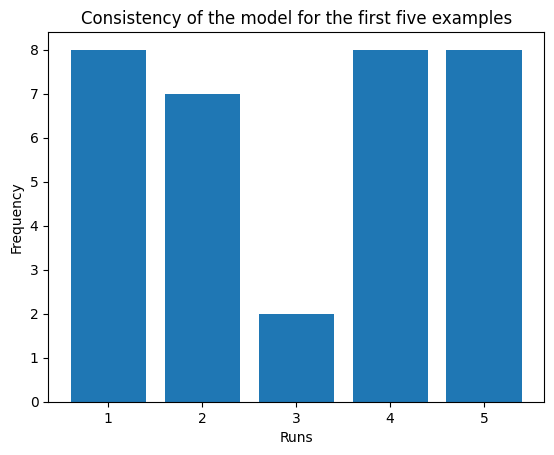

In [11]:
# plot consistency results of the model
x_range = range(1,6)
values = [8,7,2,8,8]
# plot
plt.bar(x_range, values)
plt.xlabel('Runs')
plt.ylabel('Frequency')
plt.title('Consistency of the model for the first five examples')
plt.show()